In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
workspaceFolder = "/home/gabor/Projects/bnn_seq_vi"
seq_args = [
    "--seed=3",
    # f"--pretrained_prior_checkpoint={workspaceFolder}/bnn_hmc/.runs/vi/regtest2/mfvi_initsigma_0.01_meaninit__opt_adam__lr_sch_i_0.001___epochs_300_wd_0.5_batchsize_1_temp_1.0__seed_11/model_step_299.pt",
    f"--dir={workspaceFolder}/bnn_hmc/.runs/sgd/visualize/",
    "--dataset_name=regtest_1",
    "--model_name=bayesian_regression_const_noise",
]

In [4]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import importlib
os.chdir("../..")

In [5]:
from jax import numpy as jnp
import jax
import pandas as pd
import tensorflow.compat.v2 as tf
import argparse

from bnn_hmc.utils import checkpoint_utils
from bnn_hmc.utils import cmd_args_utils
from bnn_hmc.utils import logging_utils
from bnn_hmc.utils import train_utils
from bnn_hmc.utils import optim_utils
from bnn_hmc.utils import script_utils
from bnn_hmc.core import vi

parser = argparse.ArgumentParser(description="Run SGD on a cloud TPU")
cmd_args_utils.add_common_flags(parser)
cmd_args_utils.add_sgd_flags(parser)
parser.add_argument("--vi_sigma_init", default=1e-3)

args = parser.parse_args(seq_args)
train_utils.set_up_jax(args.tpu_ip, args.use_float64)

2024-09-15 21:31:43.749932: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-09-15 21:31:44.686630: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
VI_POSTERIOR_CHECKPOINT_DIR = f"{workspaceFolder}/bnn_hmc/.runs/vi/regtest_const_noise/"\
      "mfvi_initsigma_0.1_meaninit__opt_adam__lr_sch_i_0.02___epochs_200_wd_0.1_batchsize_1_temp_1.0__seed_11"
                        #   "model_step_299.pt"
VI_ENSEMBLE_PREDICT_SIZE = 500

In [7]:
checkpoints = filter(lambda s: s.startswith("model_step_"), os.listdir(VI_POSTERIOR_CHECKPOINT_DIR))
checkpoint_iters = map(lambda s: int(re.match(r"^model_step_(\d+).pt", s).group(1)), checkpoints)
checkpoints = [f"model_step_{iter}.pt" for iter in sorted(checkpoint_iters)]
checkpoint_files = {
    checkpoint: os.path.join(VI_POSTERIOR_CHECKPOINT_DIR, checkpoint)
    for checkpoint in checkpoints
}

In [8]:
{
    checkpoint: checkpoint_utils.load_checkpoint(checkpoint_file)['params']
    for checkpoint, checkpoint_file in checkpoint_files.items()
}

{'model_step_0.pt': {'inv_softplus_std': {'linear': {'b': Array([-2.2321675], dtype=float32),
    'w': Array([[-2.2321675]], dtype=float32)}},
  'mean': {'linear': {'b': Array([0.69084203], dtype=float32),
    'w': Array([[-0.69084203]], dtype=float32)}}},
 'model_step_50.pt': {'inv_softplus_std': {'linear': {'b': Array([-1.4683027], dtype=float32),
    'w': Array([[-1.4924006]], dtype=float32)}},
  'mean': {'linear': {'b': Array([1.0277597], dtype=float32),
    'w': Array([[-1.0277597]], dtype=float32)}}},
 'model_step_100.pt': {'inv_softplus_std': {'linear': {'b': Array([-1.1727155], dtype=float32),
    'w': Array([[-1.1647561]], dtype=float32)}},
  'mean': {'linear': {'b': Array([0.99487585], dtype=float32),
    'w': Array([[-0.99487585]], dtype=float32)}}},
 'model_step_150.pt': {'inv_softplus_std': {'linear': {'b': Array([-1.098582], dtype=float32),
    'w': Array([[-1.0473567]], dtype=float32)}},
  'mean': {'linear': {'b': Array([0.99610066], dtype=float32),
    'w': Array([[-0.9

In [9]:
def process_checkpoint_file(checkpoint_file, ax=None):
    (train_set, test_set, net_apply, params, net_state, key, log_likelihood_fn,
     log_prior_fn, _, predict_fn, ensemble_upd_fn, metrics_fns,
     tabulate_metrics) = script_utils.get_data_model_fns(args)
    test_x = test_set[0][0, ..., 0]

    posterior_params = checkpoint_utils.load_checkpoint(checkpoint_file)['params']

    # Convert the model to MFVI parameterization
    net_apply, mean_apply, _, _posterior_params, net_state = vi.get_mfvi_model_fn(
        net_apply, posterior_params, net_state, seed=0, sigma_init=args.vi_sigma_init)
    # prior_kl = vi.make_kl_with_gaussian_prior(args.weight_decay, args.temperature)

    num_devices = len(jax.devices())
    net_state = jax.pmap(lambda _: net_state)(jnp.arange(num_devices))

    def vi_ensemble_predict_fn(net_apply, params, net_state, ds):
        net_state, all_preds = jax.lax.scan(
            lambda state, _: predict_fn(net_apply, params, state, ds),
            init=net_state,
            xs=jnp.arange(VI_ENSEMBLE_PREDICT_SIZE))

        ensemble_predictions = None
        num_ensembled = 0
        for pred in all_preds:
            ensemble_predictions = ensemble_upd_fn(ensemble_predictions,
                                                    num_ensembled, pred)
            num_ensembled += 1
        return net_state, ensemble_predictions, all_preds

    net_state, test_predictions, all_preds = vi_ensemble_predict_fn(net_apply, posterior_params, net_state, test_set)
    posterior_mean = test_predictions[0, ..., 0]
    posterior_mean_std = pd.DataFrame(all_preds[...,0,:,0]).std(axis=0)
    predictive_std = test_predictions[0, ..., 1]

    if not ax:
        fig, ax = plt.subplots()
    ax.errorbar(test_x, posterior_mean, yerr=predictive_std)
    ax.fill_between(test_x, posterior_mean-posterior_mean_std, posterior_mean+posterior_mean_std, alpha=0.4)
    ax.hlines(y=0, xmin=-2, xmax=2, alpha=0.2)

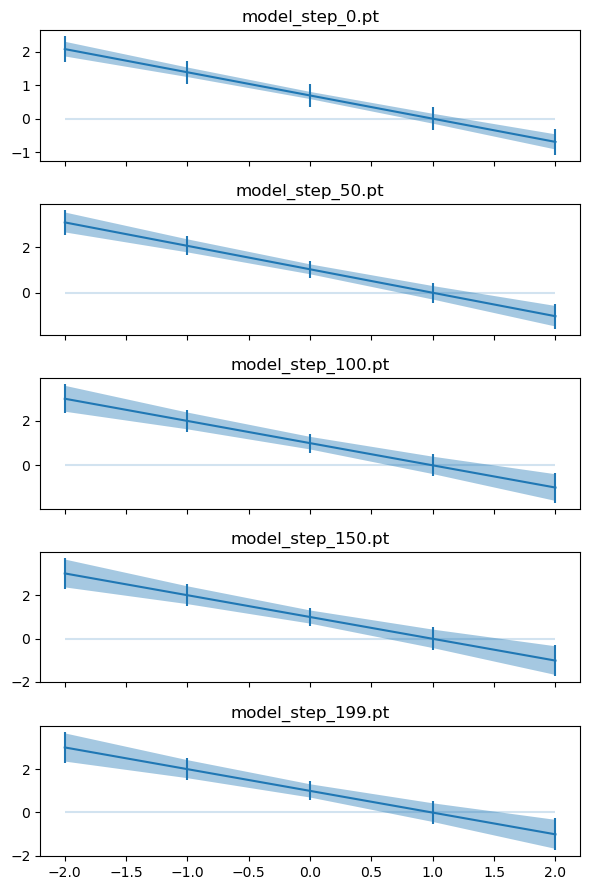

In [10]:
fig, axs = plt.subplots(nrows=len(checkpoint_files), figsize=(6, 9),#(len(checkpoint_files)*100, 400))
                        sharex=True, sharey=False)
for (checkpoint, checkpoint_file), ax in zip(checkpoint_files.items(), axs.ravel()):
    ax.set_title(checkpoint)
    process_checkpoint_file(checkpoint_file, ax=ax)
fig.tight_layout()
plt.show()